In [0]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import numpy as np

from tqdm.notebook import tqdm # progress bar

import torch.backends.cudnn as cudnn # tuninig
from IPython.display import clear_output

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")     #Check whether a GPU is present.

# Loading Data

## Model

In [0]:
class GeneratorNet(torch.nn.Module):
  
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784
        
        self.layer1 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.layer2 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.layer3 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.out(x)
        return x
    


## loading generators

In [0]:
generator_MNIST = GeneratorNet()

In [0]:
generator_FASHION = GeneratorNet()

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
model_save_name = 'GAN_MNIST.pt'
path = F"/content/gdrive/My Drive/Colab Notebooks/ComputerVision/MNIST/{model_save_name}" 
checkpoint = torch.load(path)
generator_MNIST.load_state_dict(checkpoint['generator_state_dict'])
noise_MNIST = checkpoint["test_noise"]

In [0]:
model_save_name = 'GAN_FASHION.pt'
path = F"/content/gdrive/My Drive/Colab Notebooks/ComputerVision/MNIST/{model_save_name}" 
checkpoint = torch.load(path)
generator_FASHION.load_state_dict(checkpoint['generator_state_dict'])
noise_FASHION = checkpoint["test_noise"]

In [0]:
with torch.no_grad():
    sample = Variable(torch.randn(16, 100))
    sample = (generator_FASHION(sample)+1)/2
    save_name = "sample_test.png"
    save_image(sample.view(16, 1, 28, 28),
              F"/content/gdrive/My Drive/Colab Notebooks/ComputerVision/MNIST/results(AE_Fashion)/{save_name}")

In [0]:
noise_FASHION.max()

tensor(3.4818, device='cuda:0')

# Model

In [0]:
# Writing our model
class Autoencoder(nn.Module):
    def __init__(self, generator):
        super(Autoencoder,self).__init__()
        self.decoder = generator.eval()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=9),
            nn.ReLU(True),
            nn.Conv2d(6, 6, kernel_size=7),
            nn.ReLU(True),
            nn.Conv2d(6,1,kernel_size=5),
            nn.ReLU(True)
            )
        
    def forward(self,x):
        x = self.encoder(x).view(x.size()[0],100)
        x = self.decoder(x).view(x.size()[0],1,28,28)
        return x

In [0]:
# Writing our model
class Autoencoder(nn.Module):
    def __init__(self, generator):
        super(Autoencoder,self).__init__()
        self.decoder = generator.eval()

        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(True),
            nn.Linear(256, 100)
            )


    def forward(self,x):
        x = self.encoder(x.view(x.size()[0],784)).view(x.size()[0],100)
        x = self.decoder(x).view(x.size()[0],1,28,28)
        return x

# Train

In [0]:
num_epochs = 5 

model_FASHION = Autoencoder(generator_FASHION)
distance = nn.MSELoss()
optimizer = torch.optim.Adam(model_FASHION.encoder.parameters(),weight_decay=1e-5)

In [0]:
model_FASHION.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

In [0]:
def train(epoch, model, generator):    
    model.train()
    train_loss = 0
    
    for _ in tqdm(range(1000)):
        samples = Variable(torch.randn(32, 100))
        with torch.no_grad():
            data = generator(samples.to(device)).view(32,1,28,28)

        output = model(data)
        loss = distance(output, data)
        train_loss+=loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('epoch: {}, loss:{:.4f}'.format(epoch, train_loss/1000))


# Test

In [0]:
# Loading and Transforming data
transform = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))
      ])

testset = tv.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False, num_workers=2)


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


In [0]:
best = 345

In [0]:

def testsave(epoch, model):
  global best
  step = 0
  test_loss = 0
  with torch.no_grad():
    for inputs, targets in tqdm(testloader):
        step += 1
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)

        test_loss += distance(outputs, inputs)
        
    

    # Save checkpoint.
  acc = test_loss/step

  print('Test set loss: {:.4f}'.format(acc))

  if acc < best:
      print('Saving.. {}'.format(epoch))
      state = {
          'model_state_dict': model.state_dict(),
      }
      save_name = 'checkpoint_2softmax.pt'
      path = F"/content/gdrive/My Drive/Colab Notebooks/ComputerVision/MNIST/results(AE_Fashion)/saveAE_fashion" 
      torch.save(state, path)
      best = acc

         

In [0]:
testsave(1, model_FASHION)


Test set loss: 0.6195
Saving.. 1


In [0]:

def test(epoch, model, test_sample):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        
        data = test_sample.to(device)
        recon_batch = model(data)
        test_loss += distance(recon_batch, data)

        if epoch%10 == 0:
            n = min(data.size(0), 8)
            comparison = torch.cat([data[:n],
                                  recon_batch.view(16, 1, 28, 28)[:n]])
            save_name = "reconstruction_" + str(epoch) + ".png"
            save_image((comparison.cpu()+1)/2,
                      F"/content/gdrive/My Drive/Colab Notebooks/ComputerVision/MNIST/results(AE_Fashion)/{save_name}", nrow=n)

    test_loss /= 16
    print('Test set loss: {:.4f}'.format(test_loss))


In [0]:
test(0, model_FASHION, generator_FASHION(Variable(torch.randn(16, 100)).to(device)).view(16,1,28,28))

Test set loss: 0.0506


In [0]:
torch.randn(16, 100)

tensor([[ 0.7271, -0.7713,  0.6787,  ..., -0.1858, -1.4053, -0.6718],
        [-0.4202,  2.1304, -0.1957,  ..., -0.3573, -0.5275,  1.1167],
        [ 0.8207,  0.4842, -0.0485,  ...,  1.5150, -1.4400, -0.2378],
        ...,
        [-2.2543,  3.2895, -0.6443,  ...,  1.5207,  1.1420, -1.9610],
        [ 0.5869,  1.4795, -1.1248,  ..., -1.5866,  0.2303,  0.5621],
        [ 1.4451, -0.2212, -1.1403,  ...,  0.3650, -0.7877,  2.3553]])

# Main


In [0]:
x=next(iter(testloader))

In [0]:
test_sample = generator_FASHION(noise_FASHION).view(16,1,28,28)
epoch = 0

In [0]:
for i in range(1, 1000):
    epoch += 1

    train(epoch, model_FASHION, generator_FASHION)
    test(epoch, model_FASHION, x[0])
    testsave(1,model_FASHION)
    if i%10 == 0:
      clear_output()
       

In [0]:
best

tensor(0.1185, device='cuda:0')

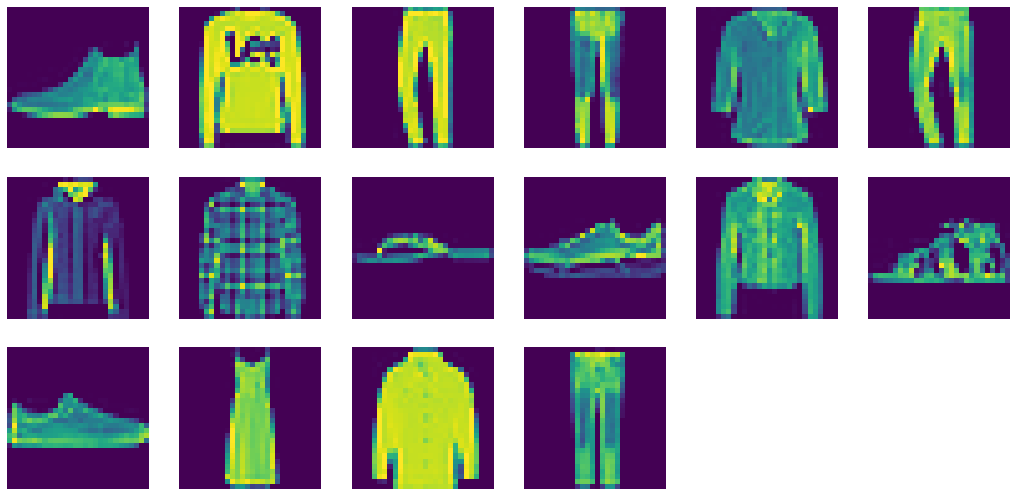

In [0]:
samples, labels  = x
samples = samples.to(device)
labels = labels * 0 

fig = plt.figure(figsize=(18, 12))
fig.tight_layout()

for num, sample in enumerate(samples[:24]):
    plt.subplot(4,6,num+1)
    
    plt.axis('off')
    sample = sample.cpu().numpy()

    plt.imshow((sample[0]+1)/2) # np.transpose(sample, (1,2,0))

In [0]:
# fig = plt.figure(figsize=(30, 10))
img = x[0][9]

plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(img.numpy()[0])

with torch.no_grad():

  output = model_FASHION.encoder(img.view(1,1,28,28).to(device))
  
with torch.no_grad():

  plt.subplot(1,2,2)
  plt.axis('off')
  decoded = model_FASHION.decoder(output.view(1,100)).view(1,28,28)
  plt.imshow((decoded.cpu().numpy()[0]+1) /2)



# Saving

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
model_save_name = 'AE_FASHION3.pt'
path = F"/content/gdrive/My Drive/Colab Notebooks/ComputerVision/MNIST/{model_save_name}" 
torch.save({
    'model_state_dict': model_FASHION.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epoch,
    "test_sample": test_sample
    }, path)

In [0]:
model_save_name = 'AE_FASHION2.pt'
path = F"/content/gdrive/My Drive/Colab Notebooks/ComputerVision/MNIST/{model_save_name}" 
checkpoint = torch.load(path)
model_FASHION.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
test_sample = checkpoint['test_sample']


# References

https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf (intuition)

https://github.com/pytorch/examples/blob/master/vae/main.py